## Linear Regression

In this notebook we implement some basic techniques for the [regression problem](https://en.wikipedia.org/wiki/Regression_analysis)<br>
Among them:<br>
* [Lagrange polynomial](https://en.wikipedia.org/wiki/Lagrange_polynomial)<br>
* [Ordinary Least Squares](https://en.wikipedia.org/wiki/Ordinary_least_squares)<br>
* [Gradient Descent](https://en.wikipedia.org/wiki/Gradient_descent) (via sklearn for polynomial regression)<br>
* [Spline approximation](https://en.wikipedia.org/wiki/Multivariate_adaptive_regression_splines)<br>


In [26]:
import os, random
import numpy as np
import matplotlib.pyplot as plt
import sympy

from itertools import repeat
from sklearn.metrics import mean_squared_error
from scipy.interpolate import make_interp_spline,BSpline
%matplotlib inline

### Tools: visualization + data generation

In [6]:
#visualization method
def visualize(X,Y,X_test,Y_test,X_pred=[],Y_pred=[]):
    plt.figure(figsize=(16,8))
    
    plt.plot(X,Y,'ro',label='train points')
    plt.plot(X_test,Y_test,'go',label='test points')
    
    if Y_pred:
        if X_pred:
            plt.plot(X_pred,Y_pred,'#222222',label = 'regression line')
        else:
            plt.plot(X_test,Y_pred,'#222222',label = 'regression line')
    plt.legend()
    plt.axis([-2.25, 2.25, -0.25, 1.25])
    plt.show()

In [27]:
#functions used for testing
def x_func_1_train(x,n):
    return 4*(x-1)/(n-1)-2
def x_func_1_test(x,n):
    return 4*(x-0.5)/(n-1)-2
def y_func_1(x):
    return 1/(1+25*x*x)

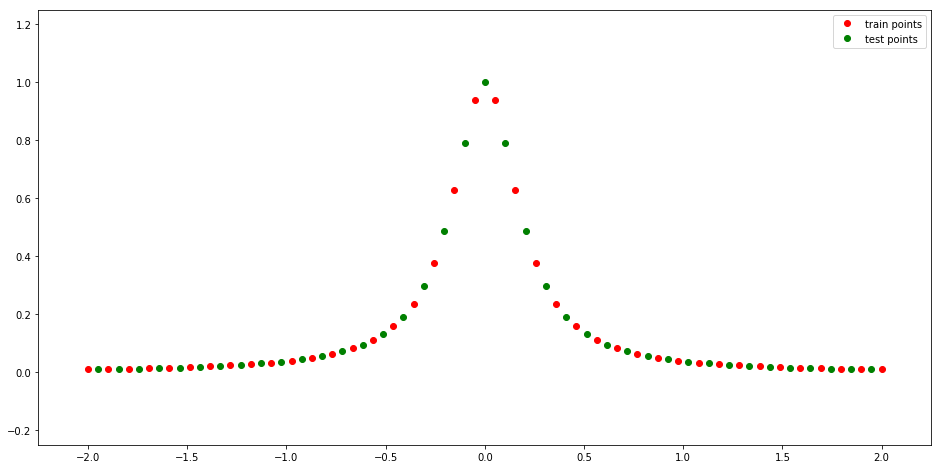

In [28]:
n = 40 #number of data points
x_train,x_test = [x_func_1_train(i,n) for i in range(1,n+1)],[x_func_1_test(i,n) for i in range(1,n)]
y_train,y_test = [y_func_1(i) for i in x_train],[y_func_1(i) for i in x_test]
visualize(x_train,y_train,x_test,y_test)

### I. [Lagrange interpolation polynomial](https://en.wikipedia.org/wiki/Lagrange_polynomial)

* Firstly, we form L(x) using train data:  $L(x):= \sum\limits_{j=0}^k y_jl_j(x)$ <br>
* For each $j$: $l_j(x):= \prod\limits_{m=0,m!=j}^k \frac{x-x_m}{x_j-x_m} $
* Secondly, we calculate predictions using L(x), for any x from a test set
* Thirdly, we smoothen generated graph using <a href ='#spline'>splines</a>

In [14]:
#correct implementation: fit using train, generate an equation, then use to evaluate test
def LagrangePolynomial_fit(X,Y):
    x,n = sympy.Symbol('x'),len(X)
    function = 0
    for i in range(n):
        def L(i):
            Lv = 1
            for j in range(n):
                if i!=j:
                    Lv*=(x - X[j])/(X[i]-X[j])
            return Lv
        function+=Y[i]*L(i)
        #function = function.simplify()
    return function

def LagrangePolynomial_predict(x,function):
    return function.subs({'x':x})

def testLagrange(X_train,Y_train,X_test,Y_test):
    lagrange_func = LagrangePolynomial_fit(X_train,Y_train)
    Y_pred = [LagrangePolynomial_predict(x,lagrange_func) for x in X_test]
    loss = mean_squared_error(Y_test,Y_pred)
    print("Loss: {0}".format(loss))
    #visualize(X_train,Y_train,X_test,Y_test,Y_pred=Y_pred)
    return Y_pred

Loss: 15186988665.956299


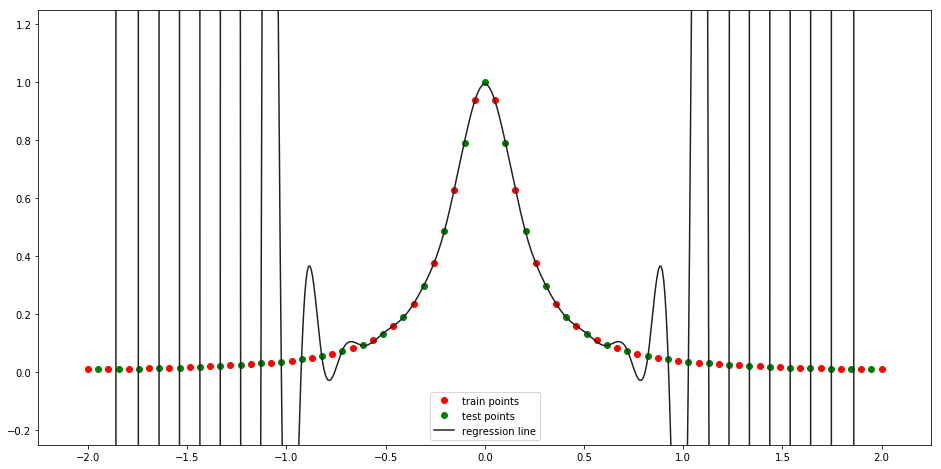

In [15]:
Y_pred = testLagrange(x_train,y_train,x_test,y_test)
xnew = np.linspace(min(x_test),max(x_test), 600)
spl = make_interp_spline(x_test,Y_pred,k=3)
power_smooth = spl(xnew)
visualize(x_train,y_train,x_test,y_test,X_pred=list(xnew),Y_pred=list(power_smooth))

### II. [Ordinary Least squares](https://towardsdatascience.com/linear-regression-simplified-ordinary-least-square-vs-gradient-descent-48145de2cf76)

* m,b are calculated using train data:
<center><font size=4>$ m = \sum_{1}^{n} \frac{(x_i-avg(x))*(y_i-avg(y))}{(x_i-avg(x))^2}; $</font><font size =3>$b = avg(Y) - m * avg(X)$</font></center>
* predictions are made using test data:
<font size= 4>$$ y_{pred} = m*x_{pred}+b $$</font>
* accuracy is measured using mean-squared error based on test data:
$$ mse = \frac{1}{n} \sum_{1}^{n}({Y-Y_{pred}})^2$$


In [16]:
def OLS_fit(X,Y):
    x_mean, y_mean = sum(X)/len(X), sum(Y)/len(Y)
    m = sum((x-x_mean)*(y-y_mean) for x,y in zip(X,Y))/sum((x-x_mean)**2 for x in X)
    b = y_mean - m * x_mean
    return m,b

def OLS_predict(x,m,b):
    return m*x+b

def test_OLS(X_train,Y_train,X_test,Y_test):
    m,b = OLS_fit(X_train,Y_train)
    Y_pred = [OLS_predict(i,m,b) for i in X_test]
    error = mean_squared_error(Y_test,Y_pred)
    visualize(X_train,Y_train,X_test,Y_test,Y_pred=Y_pred)
    print('mse = {0}'.format(error))

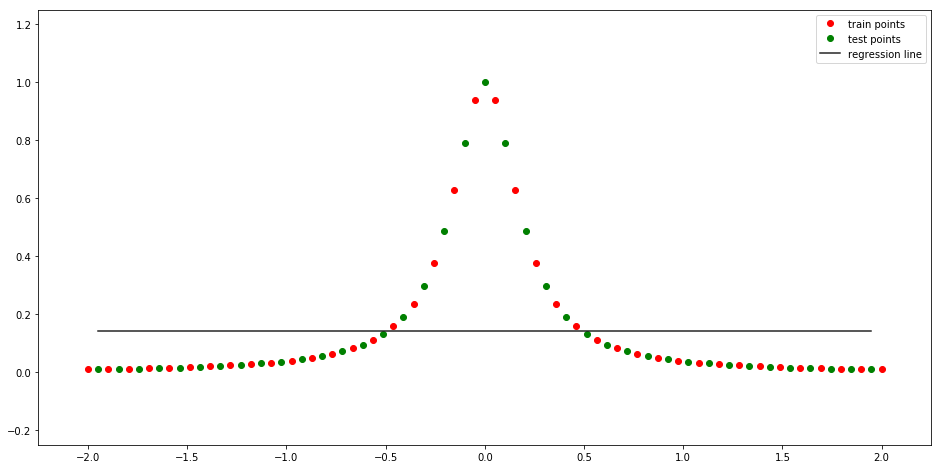

mse = 0.056885451810283864


In [17]:
test_OLS(x_train,y_train,x_test,y_test)

### III. [Linear regression using Batch Gradient Descent](https://towardsdatascience.com/linear-regression-simplified-ordinary-least-square-vs-gradient-descent-48145de2cf76)

* m,b are calculated using train data ($m*x+b<=> \theta_1*x+\theta_0$)
* training process uses parameters: $l$(learning rate), $epochs$ (num of iterations), initial $m$ and $b$ are set to 0
* iteratively, for every epoch 
    1. temporary y_pred is calculated, based on current <b>m</b> and <b>b</b>
    2. temporary derivatives $D_m$, $D_b$ are calculated:
        * $D_m = \frac{-2}{m} * \sum{x_i* (y_i - y_{pred_i})} $ 
        * $D_b =  \frac{-2}{m} * \sum{(y- y_i)}$
    3. <b>m,b</b> are updated via adding derivative*learning_rate
* prediction and calculating accuracy are similar to the OLS

In [18]:
def GD_fit(X,Y,l=0.0001,epochs = 1000):
    """
    Arguments:
    l -- learning rate
    epochs -- number of iterations
    X -- training set of X
    Y -- training set of Y
    Output:
    m,b -- params of Y = m*X+b - m is the slope, b is the intercept
    """
    n,m,b =len(X),0,0 #initial values
     
    for i in range(epochs):
        Y_pred = [m*x_i+b for x_i in X]
        D_m = (-2/n) * sum(x_i *(y_i-y_pred_i) for x_i,y_i,y_pred_i in zip(X,Y,Y_pred))
        D_b = (-2/n) * sum(y-y_i for y,y_i in zip(Y,Y_pred))
        m-=l*D_m
        b-=l*D_b
    return m,b


def GD_predict(x,m,b):
    return m*x + b


def test_GD(X_train,Y_train,X_test,Y_test):
    m,b = GD_fit(X_train,Y_train,0.002,1250)
    Y_pred = [GD_predict(i,m,b) for i in X_test]
    loss = mean_squared_error(Y_test,Y_pred)
    print("loss = {0}".format(loss))
    visualize(X_train,Y_train,X_test,Y_test,Y_pred=Y_pred)

loss = 0.05689296359909424


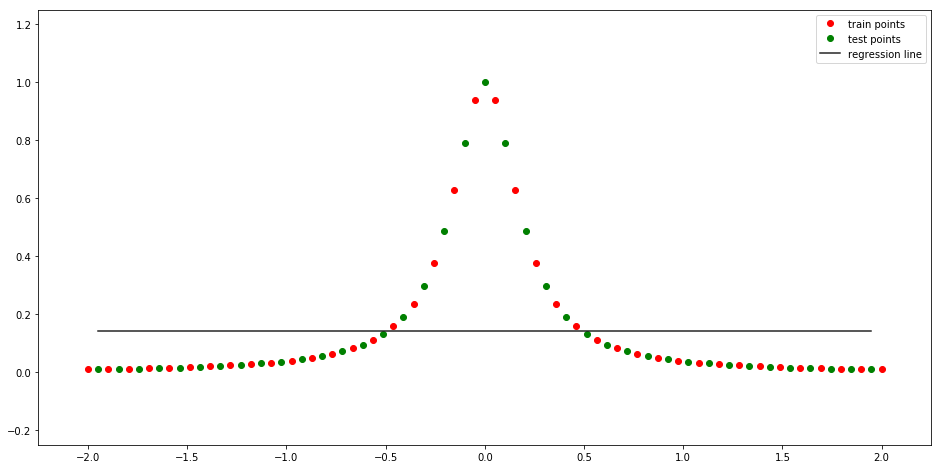

In [19]:
test_GD(x_train,y_train,x_test,y_test)

### Gradient descent - adding polynomial features

* Uses function $h(x) = \sum_{i=0}^d {\theta_i*x^i}$, where d is a max degree of poly features
* Learning process is very similar

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
def polynomial_regression_fit(X,Y,d):
    poly_features = PolynomialFeatures(degree = d)
    X_poly = poly_features.fit_transform(np.reshape(X,(-1,1)))
    model = LinearRegression().fit(X_poly,Y)
    return model


def polynomial_regression_predict(X,model,d):
    poly_features = PolynomialFeatures(degree = d)
    X_poly = poly_features.fit_transform(np.reshape(X,(-1,1)))
    Y_pred = model.predict(X_poly)
    return Y_pred
        
def polynomial_regression_test(X,Y,X_test,Y_test,d):
    model = polynomial_regression_fit(X,Y,d)
    Y_pred = polynomial_regression_predict(X_test,model,d)
    loss = mean_squared_error(Y_test,Y_pred)
    print("loss: {0}".format(loss)) 
    visualize(X,Y,X_test,Y_test,Y_pred=list(Y_pred))


loss: 0.03847955119354933


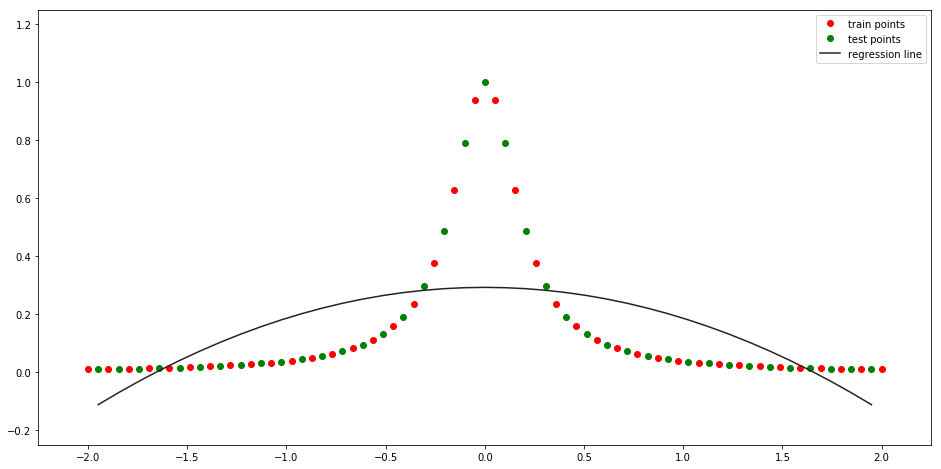

In [21]:
polynomial_regression_test(x_train,y_train,x_test,y_test,3)

loss: 0.025970821733497323


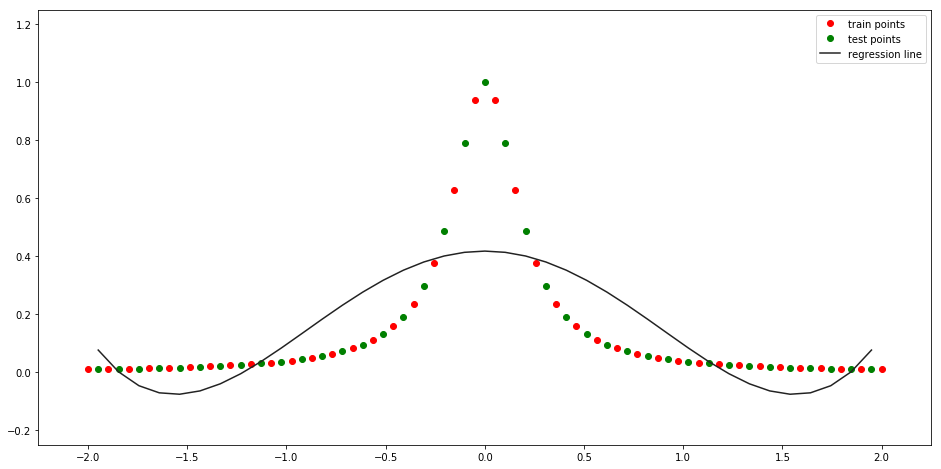

In [30]:
polynomial_regression_test(x_train,y_train,x_test,y_test,4)

### IV. Spline approx
<a id='spline'></a>

* For each point in $test$:
    * Find two closest points $(x_0,y_0), (x_1,y_1)$ from $train$
    * For $i$ in $test$, <font size=5>$y_{test_i} = y_1 + (y_2 - y_1) * \frac{(x_{test_i} - x_1)}{(x_2-x_1)}$</font>


Error: 0.00012214225764195467


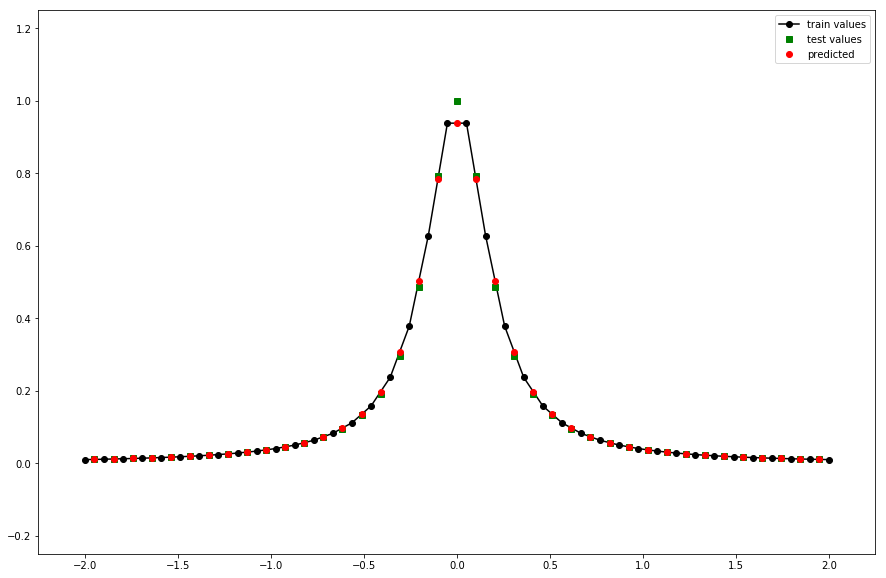

In [35]:
def getNeighbours(x,y, elem):
    if elem <= x[0]:
        return [(x[0],y[0]),(x[1],y[1])]
    if elem >= x[len(x)-1]:
        return [(x[len(x)-1], y[len(y)-1]),(x[len(x)-2],y[len(y)-2])]
    else:
        for i in range(len(x)):
            if elem <= x[i]:
                return [(x[i-1],y[i-1]),(x[i],y[i])]

def calcY(x,y,el):
    x1 = getNeighbours(x,y,el)[0][0]
    x2 = getNeighbours(x,y,el)[1][0]
    y1 = getNeighbours(x,y,el)[0][1]
    y2 = getNeighbours(x,y,el)[1][1]
    return y1 + (y2-y1)*(el-x1)/(x2-x1)

def func(x,y,xk):
    arr = []
    for i in range(len(xk)):
        arr.append(calcY(x,y,xk[i]))
    return arr

prediction = func(x_train,y_train,x_test)
print("Error: {}".format(mean_squared_error(y_test, prediction)))
plt.figure(figsize=(15,10))
plt.plot(x_train,y_train,'ko-') # train
plt.plot(x_test, y_test,'gs' ) # test
plt.plot(x_test, prediction, 'ro') # predicted
plt.gca().legend(('train values','test values', 'predicted'))
plt.axis([-2.25, 2.25, -0.25, 1.25])
plt.show()

Error: 0.00012214225764195467


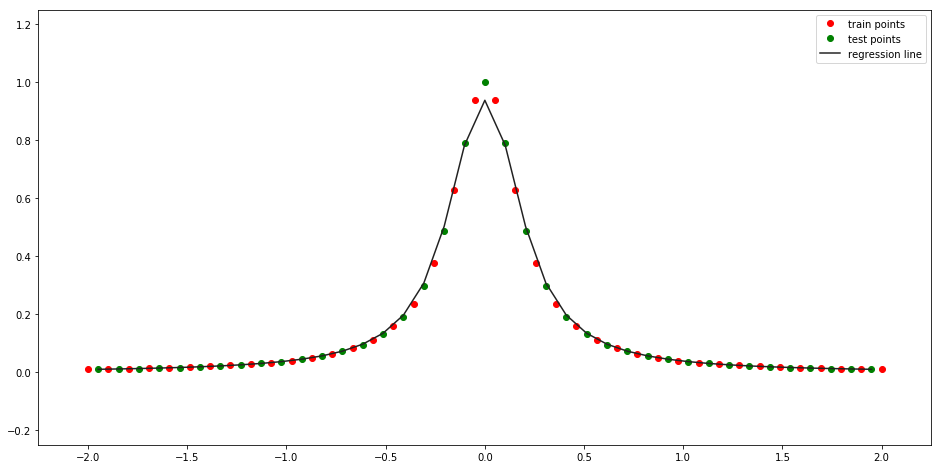

In [31]:
def getNeighbours(x,y,elem):
    if elem <= x[0]:
        return [(x[0],y[0]),(x[1],y[1])]
    elif elem >= x[len(x)-1]:
        return [x[len(x)-1],y[len(y)-1]],[x[len(x)-2],y[len(y)-2]]
    else:
        for i in range(len(x)):
            if elem <= x[i]:
                return [(x[i-1],y[i-1]),(x[i],y[i])]
            

def calculate(x,y,elem):
    n = getNeighbours(x,y,elem)
    x1,y1,x2,y2 = n[0][0],n[0][1],n[1][0],n[1][1]
    return y1 + (y2-y1)*(elem-x1)/(x2-x1)

def predict(x,y,xk):
    res = [calculate(x,y,xk[i]) for i in range(len(xk))]
    return res

prediction = predict(x_train,y_train,x_test)
print("Error: {}".format(mean_squared_error(y_test,prediction)))
visualize(x_train,y_train,x_test,y_test,Y_pred=prediction)

### Spline - polynomial features

In [23]:
from scipy.interpolate import interp1d
from scipy.interpolate import make_interp_spline, BSpline

def poly_spline(x,y, flag=False):
    c = 400 if flag else len(x)
    f2 = interp1d(x, y, kind='cubic')
    xnew = np.linspace(min(x),max(x), c)
    spl = make_interp_spline(x, f2(x), k=3) #BSpline object
    power_smooth = spl(xnew)
    return xnew,power_smooth

def test_spline(X_train,Y_train,X_test,Y_test):
    poly_tr, poly_tr_pred = poly_spline(x_train,y_train,True)
    poly_t, poly_t_pred=poly_spline(x_test,y_test)

    train_test_data = {'X_train':X_train,'Y_train':Y_train,'X_test':X_test,'Y_test':Y_test}
    spline_data = {'X_train':poly_tr,'Y_train':poly_tr_pred,'X_pred':poly_t,'Y_pred':poly_t_pred}
    return train_test_data, spline_data

def visualize_spline(train_test_data,spline_data):
    x_train,y_train,x_test,y_test = train_test_data.values()
    poly_spline_x_tr, poly_spline_y_tr, poly_spline_x_t, poly_spline_pred = spline_data.values()
    
    plt.figure(figsize=(20,10))
    plt.plot(poly_spline_x_tr, poly_spline_y_tr, 'k-') # cubic spline
    plt.plot(x_train, y_train, 'ro')
    plt.plot(x_test, y_test,'gs') 
    plt.plot(poly_spline_x_t, poly_spline_pred, 'bo')
    plt.legend(('train curve','train values', 'test values', 'predicted'))
    plt.axis([-2.25, 2.25, -0.25, 1.25])
    plt.show()

Error: 7.023471444627554e-32


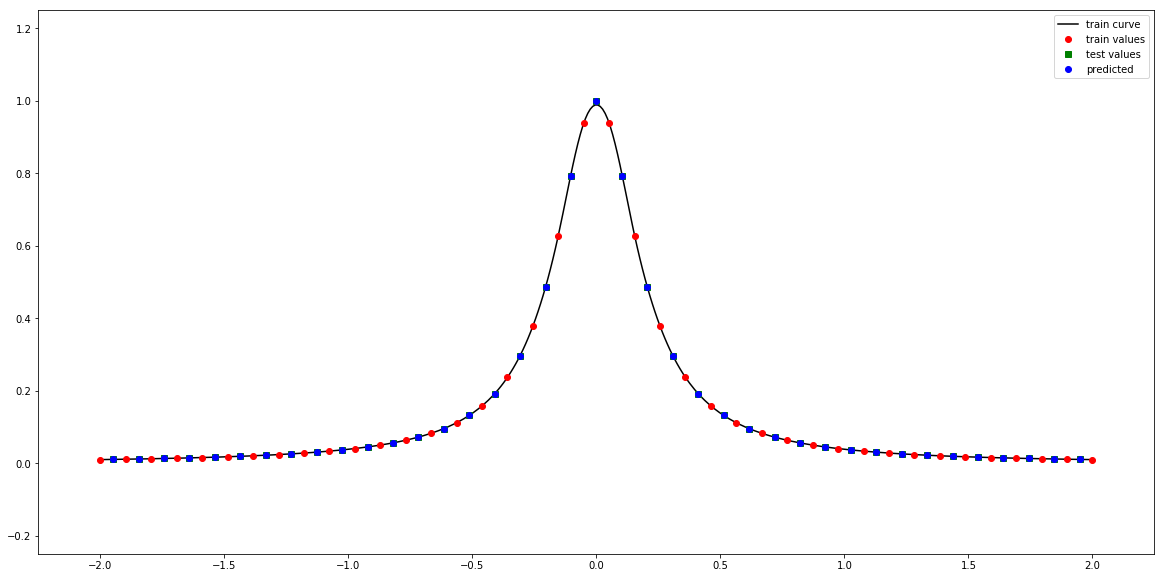

In [24]:
dataset,spline_data = test_spline(x_train,y_train,x_test,y_test)
print("Error: {}".format(mean_squared_error(y_test, spline_data['Y_pred'])))
visualize_spline(dataset,spline_data)